# Cohort 60x60 AUCs analysis including downregulated biomarkers

### Imports and environment setup

- Date of run: 2024-12-27
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [2]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [3]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Utils imports
import cohort_analysis_utils as utils

In [4]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file (available [here](<https://mimarkdx.sharepoint.com/sites/Scientific/Documentos compartidos/General/PHASE 6 - SOFTWARE DEVELOPMENT/DATA/../../../../../../:x:/s/Scientific/Eaw9d-fa2BREg_iZB1SL02YBG4mfVaJtoylG46bROmXVJA?e=8chcN7>)) was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [5]:
df_120 = pd.read_csv('../data/60x60_dr_ruo_20241209.csv' , sep='\t', index_col=0, header=0)


In [6]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)

In [7]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL', 'pH',
                    'MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'Total_protein_BCA',
                    'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

In [8]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

## Are TIMP-2 and ADIPOQ downregulated?

In [27]:
df_120['TIMP-2_n'] = df_120['TIMP-2'].div(df_120['Total_protein_BCA'], axis=0)
df_120['ADIPOQ_n'] = df_120['ADIPOQ'].div(df_120['Total_protein_BCA'], axis=0)
df_120['MMP9_n'] = df_120['MMP9'].div(df_120['Total_protein_BCA'], axis=0)
df_120['PERM_n'] = df_120['PERM'].div(df_120['Total_protein_BCA'], axis=0)

df_120['TIMP-2_cv'] = df_120['TIMP-2'].div(df_120['Collected_volume_mL'], axis=0)
df_120['ADIPOQ_cv'] = df_120['ADIPOQ'].div(df_120['Collected_volume_mL'], axis=0)
df_120['MMP9_cv'] = df_120['MMP9'].div(df_120['Collected_volume_mL'], axis=0)
df_120['PERM_cv'] = df_120['PERM'].div(df_120['Collected_volume_mL'], axis=0)

# drop nans and infs in cv columns
df_120 = df_120.replace([np.inf, -np.inf], np.nan)
df_120 = df_120.dropna(subset=['TIMP-2_cv', 'ADIPOQ_cv', 'MMP9_cv', 'PERM_cv'])

In [28]:
custom_palette = {0: "#f789c8", 1: "#f41c11"}  # Adjust to match your Pathology values

# Function to plot
def plot_biomarker_violinplots(df, bmk):
    df_long = df.melt(id_vars="Pathology", 
                  value_vars=[f"{bmk}", f"{bmk}_n", f"{bmk}_cv"], 
                  var_name="Feature", 
                  value_name="Value")

    # Apply log to the value column
    df_long['Value'] = np.log(df_long['Value'])

    # Create a violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_long, 
                   x="Feature", 
                   y="Value", 
                   hue="Pathology", 
                   split=True, 
                   inner="quartile",
                   palette=custom_palette)
    plt.title(f"{bmk} by Pathology")
    plt.xlabel("")
    plt.ylabel("Value")
    plt.legend(title="Pathology")
    plt.show()

### Distribution of MMP9

Not normalized, normalized and normalized by collected volume.

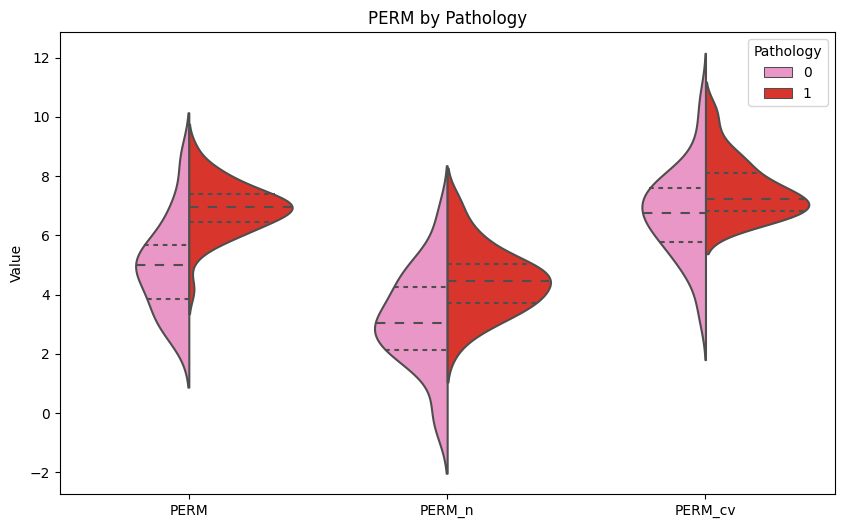

In [29]:
plot_biomarker_violinplots(df_120, 'PERM')

### Distribution of TIMP-2

Not normalized, normalized and normalized by collected volume.

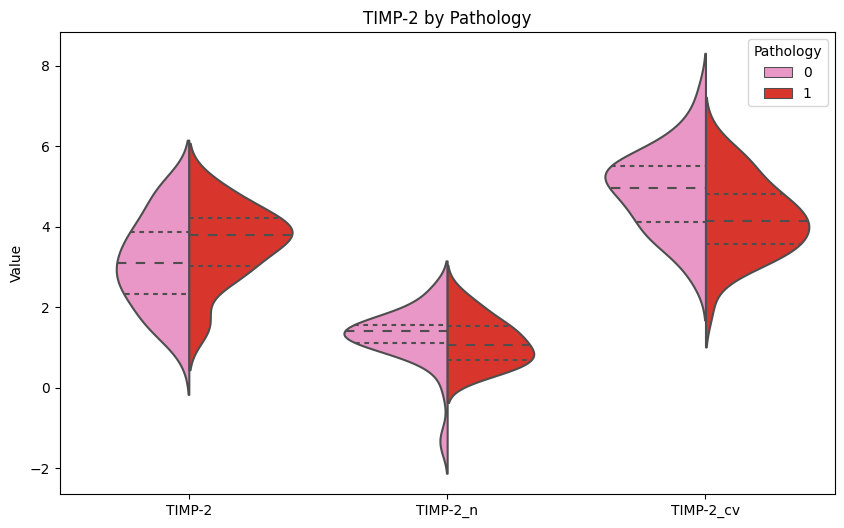

In [30]:
plot_biomarker_violinplots(df_120, 'TIMP-2')

### Distribution of ADIPOQ

Not normalized, normalized and normalized by collected volume.

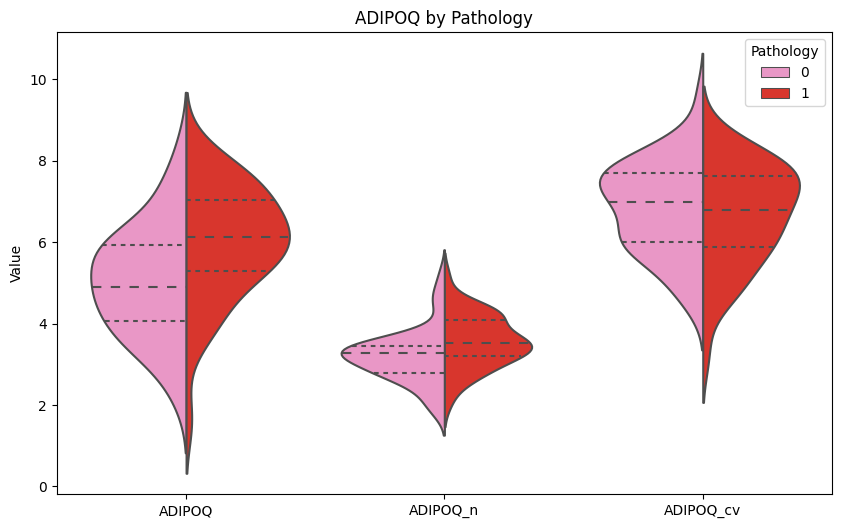

In [31]:
plot_biomarker_violinplots(df_120, 'ADIPOQ')

# Execution parameters

In [64]:
PLOT_ROCS = True
MAX_BIOMARKER_COUNT = 3
RESULTS_PATH = '../data/results/60x60_dr'

# Columns to be considered as biomarkers
BIOMARKERS_120 = ['MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2']

NORMALIZING_COL_120 = 'Total_protein_BCA' # Column to be used for normalizing the biomarkers
VOLUME_COL = 'Collected_volume_mL' # Column to be used as volume for scatters and undoing the dilution

## Methods

Description of the methods used to compute the AUCS

### Direct

No transformations were made to the readout of each biomarker.

Due to the different treatment the samples have undergone, the performance of the biomarkers in the 60x60 is masking the correlation of the target variable (disease) with the volume variable because the biomarkers (and total protein) readouts correlate with the collected volume. While the volume is a good classification variable, we want to get rid of it because we cannot control it.  

### Normalized

To get rid of the volume, the total protein variable was proposed as a normalizing variable. The values used for classification are then the ratios of the concentrations $[Bmk]/[TP]$.

About the pros and cons of this method: 
- As a pro, the total protein correlates with the volume (in the 60x60 cohort) so normalizing by it allows to get rid of the volume. 
- Total protein (unlike volume) is determined experimentally and not manually and is not extraction/technician/clinician dependent.  
- While it correlates with the volume (in the 60x60 cohort), the concentration of total protein is a variable itself. It could be explained to some extent by the volume but also by other causes, then using it as a means of getting rid of the volume could come at the price of adding a biological interpretation layer to the results. 
- After discussions with the collaborators from Santiago, they noted the fact that ratios can be misleading, especially if the denominator variable is not independent of the numerator or other variables in the analysis. 

### Undo dilution

In this method, to undo the dilution and use the samples expressed in the concentration they had in terms of their collected volume, we have applied the rule of three: 

$f.v.\to [BMK]_{f.v.}$

$c.v. \to [BMK]_{c.v.} = \frac{c.v.}{f.v.} * [BMK]_{f.v.}$


In the 240 cohort this method will have the same performance as the direct method since $c.v./f.v.$ will be always a constant (½) affecting equally all the observations. For the 60x60 cohort, the $f.v.$ is $c.v.+0.5mL$, making the ratio close to one for bigger volumes and closer to zero for smaller ones. Said that, only results for the 60x60 cohort are presented: 

In [65]:
METHODS = ['direct', 'normalized', 'undo_dilution']

# Computing the models

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

In [66]:
models_120 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            auc_threshold=0.0
                            )

Let's do the same for single biomarkers.

In [67]:
MAX_BIOMARKER_COUNT = 1

models_120_1 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            compute_auc_ci=True,
                            auc_threshold=0.0
                            )

# Results

## Direct

Here are presented the top 10 results for the direct method. Remember you can see the full results [here](<../data/results/60x60/direct/max_3.csv>) (they are stored in the folder "data/results/60x60/direct/").

In [68]:
df_results_120_direct = pd.read_csv(RESULTS_PATH+'/direct/max_3.csv', sep=',', header=0)
df_results_120_direct[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)


,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,PERM,NaN,NaN,0.85714
1,MMP9,PERM,NaN,0.84199
2,MMP9,NaN,NaN,0.83149
3,MMP9,HSPB1,TIMP-2,0.77349
4,MMP9,TIMP-2,NaN,0.73787
5,MMP9,HSPB1,ADIPOQ,0.73488
6,MMP9,ADIPOQ,TIMP-2,0.72426
7,HSPB1,PERM,TIMP-2,0.71845
8,MMP9,PERM,TIMP-2,0.69859
9,HSPB1,PERM,ADIPOQ,0.69762


Let's see also how the biomarkers performed individually.

In [69]:
df_results_120_direct[df_results_120_direct['Biomarker_2'].isnull() & df_results_120_direct['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
0,PERM,0.85714
2,MMP9,0.83149
13,ADIPOQ,0.69340
19,HSPB1,0.65814
20,TIMP-2,0.61936


## Normalized

In [70]:
df_results_120_normalized = pd.read_csv(RESULTS_PATH+'/normalized/max_3.csv', sep=',', header=0)
df_results_120_normalized[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']].head(n=10)

,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,MMP9,HSPB1,TIMP-2,0.82047
1,MMP9,PERM,TIMP-2,0.80195
2,MMP9,TIMP-2,NaN,0.79617
3,MMP9,ADIPOQ,TIMP-2,0.79362
4,HSPB1,PERM,TIMP-2,0.79345
5,PERM,TIMP-2,NaN,0.78571
6,PERM,ADIPOQ,TIMP-2,0.78247
7,MMP9,NaN,NaN,0.77872
8,MMP9,PERM,NaN,0.76623
9,PERM,NaN,NaN,0.75108


In [71]:
df_results_120_normalized[df_results_120_normalized['Biomarker_2'].isnull() & df_results_120_normalized['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
7,MMP9,0.77872
9,PERM,0.75108
14,ADIPOQ,0.67234
21,TIMP-2,0.61702
22,HSPB1,0.61209


## Undo dilution

In [72]:
df_results_120_undo_dilution = pd.read_csv(RESULTS_PATH+'/undo_dilution/max_3.csv', sep=',', header=0)
df_results_120_undo_dilution[['Biomarker_1','Biomarker_2','Biomarker_3','AUC']]

,Biomarker_1,Biomarker_2,Biomarker_3,AUC
0,PERM,NaN,NaN,0.87825
1,MMP9,PERM,NaN,0.86742
2,MMP9,NaN,NaN,0.83957
3,MMP9,PERM,TIMP-2,0.77814
4,PERM,TIMP-2,NaN,0.77706
5,MMP9,TIMP-2,NaN,0.77191
6,MMP9,HSPB1,TIMP-2,0.76930
7,ADIPOQ,NaN,NaN,0.76000
8,MMP9,HSPB1,NaN,0.76000
9,MMP9,HSPB1,ADIPOQ,0.75814


In [73]:
df_results_120_undo_dilution[df_results_120_undo_dilution['Biomarker_2'].isnull() & df_results_120_undo_dilution['Biomarker_3'].isnull()][['Biomarker_1','AUC']]

,Biomarker_1,AUC
0,PERM,0.87825
2,MMP9,0.83957
7,ADIPOQ,0.76000
15,HSPB1,0.74512
20,TIMP-2,0.72362


## AUCs confidence interval

AUCs confidence intervals are computed with the bootstraping method. Bootstrapping to compute confidence intervals for AUC involves repeatedly resampling the original dataset with replacement to create many bootstrap samples, calculating the AUC for each sample, and then constructing a distribution of these AUC values. The confidence interval is determined by taking the appropriate percentiles (e.g., 2.5th and 97.5th for a 95% CI) from the sorted bootstrap AUC values, providing a range that estimates where the true AUC likely falls.

In [96]:
aucs = []
auc_cis = []
models = []

for model in models_120_1['normalized'][(list(models_120_1['normalized'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_120_1['normalized'][(list(models_120_1['normalized'].keys())[0])][model]['auc']
    model_auc_ci = models_120_1['normalized'][(list(models_120_1['normalized'].keys())[0])][model]['auc_ci']
    aucs.append(float(model_auc))
    auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models.append(model_name)

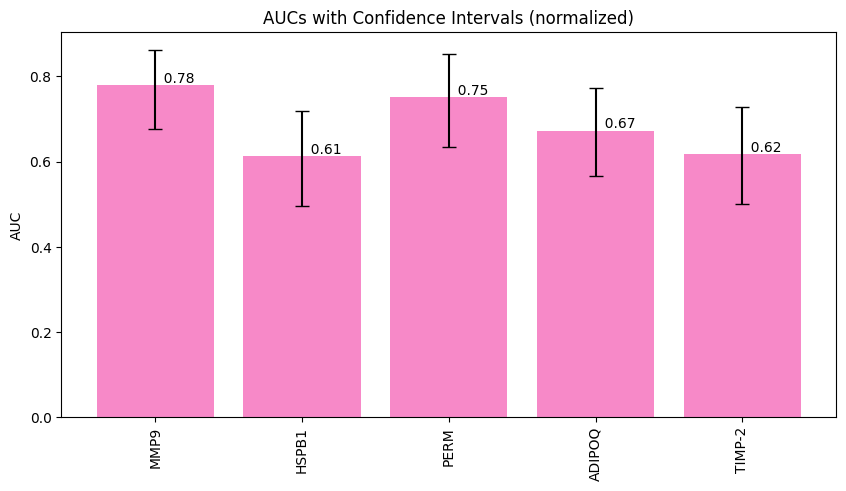

In [98]:
auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(models, aucs, yerr=yerr, capsize=5, align='center', color=custom_palette[0])

# Add text with the value of the bar in the middle of it
for i in range(len(models)):
    plt.text(i, aucs[i], f"  {round(aucs[i], 2)}", ha='left', va='bottom')

plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals (normalized)')
plt.show()